# BBM409 Glass Classification

Here we can write

## Introduction

In [19]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

In [20]:
def k_fold(x, is_weighted):
    # start and end points of each fold (for 214 rows of data 43+43+43+43+42)
    arr = [0, 43, 86, 129, 172, 215]
    for i in range(5):
        # 1/5 part of the data set as test data
        x_test = x[arr[i]:arr[i + 1]]

        # rest of the data set as train data
        a = x[0:arr[i]]
        b = x[arr[i + 1]:]
        x_train = np.concatenate((a, b), axis=0)

        print("--------------------------FOLD", i, "--------------------------------------------")

        # for every fold use knn classification
        knn_true_prediction_count, knn_false_prediction_count = knn_classification(x_train, x_test, is_weighted)

        print(knn_true_prediction_count)
        print(knn_false_prediction_count)
        print(".................................")

        list_accuracy = []

        for e in range(0, 9, 2):
            accuracy = \
                (100 * knn_true_prediction_count[e]) / (knn_true_prediction_count[e] + knn_false_prediction_count[e])
            print("Accuracy for (KNN) k=", (e + 1), " : ", accuracy)
            list_accuracy.append(accuracy)

        plt.plot([1, 3, 5, 7, 9], list_accuracy)
        plt.axis([0, 9, 0, 100])
    return

In [21]:
def normalize(x):
    for i in range(0, x.shape[1] - 2):
        col = []
        for k in range(x.shape[0]):
            col.append(x[k, i])
        col.sort()
        min_of_col = col[0]
        max_of_col = col[x.shape[0] - 1]

        for j in range(x.shape[0]):
            x[j, i] = (x[j, i] - min_of_col) / (max_of_col - min_of_col)
    return x


In [22]:
def calculate_predictions(x_train, sorted_keys, test, true_prediction, false_prediction):
    closest_points = []
    for i in range(9):
        closest_points.append(x_train[sorted_keys[i]][9])
        if i == 0 or i == 2 or i == 4 or i == 6 or i == 8:
            # get the most frequent output in the closest points array
            frequent = max(set(closest_points), key=closest_points.count)
            if frequent == test[9]:
                true_prediction[i] += 1
            else:
                false_prediction[i] += 1

    return true_prediction, false_prediction

In [23]:
def calculate_weighted_predictions(x_train, sorted_keys, euclidean_distances, test, true_prediction, false_prediction):
    # key=index , value=weight
    closest_points_and_weights = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
    for i in range(9):
        index = sorted_keys[i]
        if euclidean_distances.get(index) != 0:
            closest_points_and_weights[x_train[sorted_keys[i]][9]] += 1 / euclidean_distances.get(index)

        if i == 0 or i == 2 or i == 4 or i == 6 or i == 8:
            frequent = max(closest_points_and_weights, key=closest_points_and_weights.get)
            if frequent == test[9]:
                true_prediction[i] += 1
            else:
                false_prediction[i] += 1

    return true_prediction, false_prediction

In [24]:
def knn_classification(x_train, x_test, is_weighted):
    # array index represent k in kNN (we only use 1-3-5-7-9)
    true_prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    false_prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    for i in range(x_test.shape[0]):
        test = x_test[i]
        euclidean_distances = {}
        for j in range(0, x_train.shape[0]):
            ri = x_train[j][0] - test[0]
            na = x_train[j][1] - test[1]
            mg = x_train[j][2] - test[2]
            al = x_train[j][3] - test[3]
            si = x_train[j][4] - test[4]
            k = x_train[j][5] - test[5]
            ca = x_train[j][6] - test[6]
            ba = x_train[j][7] - test[7]
            fe = x_train[j][8] - test[8]
            euc_dist = math.sqrt(
                # (ri * ri) + (ca * ca) + (mg * mg) + (na * na))
                # (al * al) + (mg * mg) )
                (ri * ri) + (ca * ca) + (mg * mg) + (na * na) + (al * al) + (si * si) + (k * k) + (ba * ba) + (fe * fe))

            euclidean_distances[j] = euc_dist

        # sort by the value of euclidean distance, first element will be the nearest point
        sorted_keys = sorted(euclidean_distances, key=euclidean_distances.get)

        sorted_keys = sorted_keys[:9]

        if is_weighted == False:
            # classify predictions as true or false by looking first 1,3,5,7,9 neighbors
            true_prediction, false_prediction = calculate_predictions(x_train, sorted_keys, test,
                                                                      true_prediction, false_prediction)
        else:
            true_prediction, false_prediction = calculate_weighted_predictions(x_train, sorted_keys,
                                                                               euclidean_distances,
                                                                               test, true_prediction, false_prediction)

    return true_prediction, false_prediction

In [25]:
def knn(x):
    k_fold(x, False)
    plt.ylabel("KNN")
    plt.show()

In [26]:
def knn_with_normalization(x):
    x = normalize(x)
    k_fold(x, False)
    plt.ylabel("KNN-NORM")
    plt.show()


In [27]:
def weighted_knn(x):
    k_fold(x, True)
    plt.ylabel("W-KNN")
    plt.show()


In [28]:
def weighted_knn_with_normalization(x):
    x = normalize(x)
    k_fold(x, True)
    plt.ylabel("W-KNN-NORM")
    plt.show()

In [39]:
df = pd.read_csv('~/Desktop/BBM406&409/First Assignment/glass.csv')
x = np.array(df.iloc[:, :])

np.random.seed(101)
np.random.shuffle(x)

KNN

--------------------------FOLD 0 --------------------------------------------
[31, 0, 27, 0, 24, 0, 26, 0, 25]
[12, 0, 16, 0, 19, 0, 17, 0, 18]
.................................
Accuracy for (KNN) k= 1  :  72.09302325581395
Accuracy for (KNN) k= 3  :  62.7906976744186
Accuracy for (KNN) k= 5  :  55.81395348837209
Accuracy for (KNN) k= 7  :  60.46511627906977
Accuracy for (KNN) k= 9  :  58.13953488372093
--------------------------FOLD 1 --------------------------------------------
[30, 0, 30, 0, 32, 0, 27, 0, 28]
[13, 0, 13, 0, 11, 0, 16, 0, 15]
.................................
Accuracy for (KNN) k= 1  :  69.76744186046511
Accuracy for (KNN) k= 3  :  69.76744186046511
Accuracy for (KNN) k= 5  :  74.4186046511628
Accuracy for (KNN) k= 7  :  62.7906976744186
Accuracy for (KNN) k= 9  :  65.11627906976744
--------------------------FOLD 2 --------------------------------------------
[30, 0, 29, 0, 25, 0, 26, 0, 28]
[13, 0, 14, 0, 18, 0, 17, 0, 15]
.................................
Accu

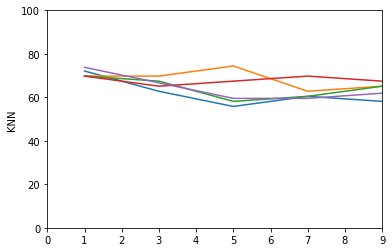

In [38]:
print("KNN\n")
knn(x.copy())

KNN WITH NORMALIZATION

--------------------------FOLD 0 --------------------------------------------
[31, 0, 29, 0, 28, 0, 26, 0, 27]
[12, 0, 14, 0, 15, 0, 17, 0, 16]
.................................
Accuracy for (KNN) k= 1  :  72.09302325581395
Accuracy for (KNN) k= 3  :  67.44186046511628
Accuracy for (KNN) k= 5  :  65.11627906976744
Accuracy for (KNN) k= 7  :  60.46511627906977
Accuracy for (KNN) k= 9  :  62.7906976744186
--------------------------FOLD 1 --------------------------------------------
[33, 0, 33, 0, 32, 0, 29, 0, 31]
[10, 0, 10, 0, 11, 0, 14, 0, 12]
.................................
Accuracy for (KNN) k= 1  :  76.74418604651163
Accuracy for (KNN) k= 3  :  76.74418604651163
Accuracy for (KNN) k= 5  :  74.4186046511628
Accuracy for (KNN) k= 7  :  67.44186046511628
Accuracy for (KNN) k= 9  :  72.09302325581395
--------------------------FOLD 2 --------------------------------------------
[32, 0, 30, 0, 27, 0, 28, 0, 27]
[11, 0, 13, 0, 16, 0, 15, 0, 16]
..................

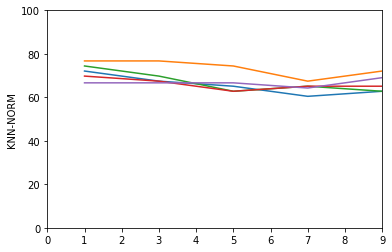

In [36]:
print("KNN WITH NORMALIZATION\n")
knn_with_normalization(x.copy())

In [1]:
print("WEIGHTED KNN\n")
weighted_knn(x.copy())

WEIGHTED KNN



NameError: name 'weighted_knn' is not defined

In [ ]:
print("WEIGHTED KNN WITH NORMALIZATION\n")
weighted_knn_with_normalization(x.copy())